## Evaluating Overdue FCEs
This notebook uses historical data of Full Compliance Evaluations dating back to 2006 and attempts to evaluate whether sources were overdue for an inspection at the time of evaluation.

It also looks at current FCE's and calculates whether the source is overdue for an inspection.

In [ ]:
import pandas as pd
import datetime
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
plt.rcParams['svg.fonttype'] = 'none'

### Reading In Data

In [71]:
# FCEs dating back to 2006 from FOIA Request
df=pd.read_excel("Full_Compliance_Evaluation_List_20220428.xlsx")

# Cleaning the dataframe
df.columns = df.columns.str.lower().str.replace(" ","_")
df.date_of_evaluation = pd.to_datetime(df.date_of_evaluation, format="%Y-%m-%d")
df.state_registrtion_number = df.state_registrtion_number.str.replace(" ","")
df.epa_class = df.epa_class.str.replace(" ","")
df = df.rename({'state_registrtion_number':'srn'},axis=1)
df.head()

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class
0,2022-03-17,P0789,"KALITTA AIR, LLC",5063 SKYWAY STREET,OSCODA,IOSCO,Bay City,SMOPTOUT
1,2022-02-28,B1991,GM LLC Saginaw Metal Casting Operations,1629 N. WASHINGTON,SAGINAW,SAGINAW,Bay City,MAJOR
2,2022-02-22,B2644,Hemlock Semiconductor Operations LLC,12334 Geddes Rd.,HEMLOCK,SAGINAW,Bay City,MAJOR
3,2022-02-10,N0854,TI GROUP AUTOMOTIVE SYSTEMS LLC - Caro Test Ce...,628 COLUMBIA ST,CARO,TUSCOLA,Bay City,MAJOR
4,2022-01-27,N1652,West Branch Production Gathering & Compressor ...,2251 SIMMONS RD,WEST BRANCH,OGEMAW,Bay City,SMOPTOUT


In [73]:
# Source Directory from FOIA Request
sources = pd.read_excel("CMS_Subject_Sources_Sheet2.xlsx")
sources.columns = sources.columns.str.lower().str.replace(" ","_")

# Getting a list of SRNs in the directory
sources_srn = sources.srn.to_list()
sources.head()

,epa_class,srn,facility_name,address,city,county,district
0,MAJOR,A0884,Verso Escanaba LLC,7100 COUNTY 426 M.5 ROAD,ESCANABA,DELTA,Marquette
1,MAJOR,A6475,UP Paper LLC.,402 West Elk Street,MANISTIQUE,SCHOOLCRAFT,Marquette
2,MAJOR,B1470,NEENAH PAPER - MICHIGAN INC,501 E MUNISING AVE,MUNISING,ALGER,Marquette
3,MAJOR,B1577,GREDE LLC - IRON MOUNTAIN,801 S CARPENTER AVE,KINGSFORD,DICKINSON,Marquette
4,MAJOR,B4260,L'ANSE WARDEN ELECTRIC COMPANY LLC,157 S MAIN STREET,LANSE,BARAGA,Marquette


In [74]:
# Active permits
pti=pd.read_csv("pti-042722-all-clean.csv")
pti.approved = pd.to_datetime(pti.approved,format="%m/%d/%Y")

#Oldest permits, so I only have one srn
pti_oldest = pti.sort_values(['srn','approved']).drop_duplicates(subset='srn')

#Getting a list of SRN's in PTI doc
pti_srn = pti.srn.to_list()

In [82]:
# Making the approved_converted the cutoff for the data
def convert (approved):
    if approved < (pd.to_datetime("2006-05-10")):
        return "2007-01-01"
    else:
        return approved
    
pti_oldest['approved_converted']=pti_oldest.approved.apply(convert)
pti_oldest.head()

/var/folders/_4/_njb58q944xdbv6xcbzbzmqh0000gn/T/ipykernel_6359/2295484237.py:8: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


,company,address,srn,approved,approved_converted
0,MENASHA CORPORATION,320 N FARMER STREET -,A0023,2001-04-12,2007-01-01
4,"SODUS HARD CHROME, INC",3085 YORE AVENUE,A0083,2015-01-14,2015-01-14
5,"PANEL PROCESSING, INC",120 N INDUSTRIAL HIGHWAY,A0085,2016-04-27,2016-04-27
6,EVERETT GOODRICH TRUCKING,5614 WESSEL ROAD,A0098,2004-11-29,2007-01-01
7,BESSER COMPANY,801 JOHNSON STREET,A0099,2000-08-08,2007-01-01


In [105]:
# Did a new scrape including SRN's I was missing
new_fce = pd.read_csv('EGLE-AQD-documents-051422.csv')
new_fce.date = pd.to_datetime(new_fce.date,format="%Y%m%d",errors='coerce')
new_fce = new_fce.query('doc_type.str.contains("fce", case=False)')
new_fce

# Pulling FCEs that are not in the FOIA database and adding them
any_new = df.merge(new_fce,how="outer",left_on=["srn","date_of_evaluation"],right_on=["source_id","date"])
any_new = any_new.query("srn.isnull()")[['source_id','date']]

# Getting source information
any_new = any_new.merge(sources,how="left",left_on="source_id",right_on="srn")
any_new = any_new.drop(['source_id'],axis=1).rename({'date':'date_of_evaluation'},axis=1)

print(len(any_new))
any_new.head()

394


,date_of_evaluation,epa_class,srn,facility_name,address,city,county,district
0,2014-04-03,SM OPT OUT,B6481,ANR Pipeline Company - Capac Compressor Station,4876 KETTLEHUT RD.,CAPAC,SAINT CLAIR,Warren
1,2014-04-02,MAJOR,B6637,Consumers Energy - St. Clair Compressor Station,10021 MARINE CITY HWY.,IRA TWP,SAINT CLAIR,Warren
2,2017-08-08,MAJOR,B2796,ST. CLAIR / BELLE RIVER POWER PLANT,4505 King Road,CHINA TWP,SAINT CLAIR,Warren
3,2020-02-07,SM OPT OUT,N0950,MICHIGAN METAL COATINGS,2015 DOVE STREET,PORT HURON,SAINT CLAIR,Warren
4,2021-04-28,SM OPT OUT,N0950,MICHIGAN METAL COATINGS,2015 DOVE STREET,PORT HURON,SAINT CLAIR,Warren


In [106]:
# Adding New FCE's to my datastet
new_df = pd.concat([df,any_new],ignore_index=True)
new_df.head()

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class
0,2022-03-17,P0789,"KALITTA AIR, LLC",5063 SKYWAY STREET,OSCODA,IOSCO,Bay City,SMOPTOUT
1,2022-02-28,B1991,GM LLC Saginaw Metal Casting Operations,1629 N. WASHINGTON,SAGINAW,SAGINAW,Bay City,MAJOR
2,2022-02-22,B2644,Hemlock Semiconductor Operations LLC,12334 Geddes Rd.,HEMLOCK,SAGINAW,Bay City,MAJOR
3,2022-02-10,N0854,TI GROUP AUTOMOTIVE SYSTEMS LLC - Caro Test Ce...,628 COLUMBIA ST,CARO,TUSCOLA,Bay City,MAJOR
4,2022-01-27,N1652,West Branch Production Gathering & Compressor ...,2251 SIMMONS RD,WEST BRANCH,OGEMAW,Bay City,SMOPTOUT


# Getting to Know the Data

In [107]:
print(sources.groupby('epa_class').srn.nunique())
sources.query("srn.isin(@pti_srn)" ).groupby('epa_class').srn.nunique()

epa_class
MAJOR         329
MEGASITE       13
SM OPT OUT    917
Name: srn, dtype: int64


epa_class
MAJOR         276
MEGASITE       12
SM OPT OUT    832
Name: srn, dtype: int64

* There are 53 major sources missing
* There is 1 megasite missing
* There are 85 opt out sources missing

In [108]:
# What sources in the source list don't have FCE's in this database?
# What are these sources and why are they without FCE's?
fce_srn = new_df.drop_duplicates(subset="srn").srn.to_list()
sources.query('~srn.isin(@fce_srn)').epa_class.value_counts()

SM OPT OUT    21
MEGASITE       4
Name: epa_class, dtype: int64

In [109]:
# distribution of years
df.resample("Y", on="date_of_evaluation").size()

date_of_evaluation
2006-12-31      6
2007-12-31    135
2008-12-31    547
2009-12-31    522
2010-12-31    468
2011-12-31    476
2012-12-31    440
2013-12-31    450
2014-12-31    465
2015-12-31    527
2016-12-31    484
2017-12-31    461
2018-12-31    461
2019-12-31    429
2020-12-31    445
2021-12-31    436
2022-12-31     88
dtype: int64

In [110]:
# What are the 6 companies they included? from 2006
df.query('date_of_evaluation < "2007-01-01"')

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class
492,2006-12-20,B2876,"Michigan Sugar Company, Croswell Factory",159 S Howard Ave,CROSWELL,SANILAC,Bay City,MAJOR
493,2006-11-02,A6174,GENERAL MOTORS - POWERTRAIN GROUP SAGINAW,77 W. Center St.,SAGINAW,SAGINAW,Bay City,MINOR
2742,2006-10-04,A0767,"EJ USA, Inc.",301 Spring St.,EAST JORDAN,CHARLEVOIX,Gaylord,MAJOR
5367,2006-11-21,B1592,Owens-Brockway Glass Container Inc.,500 Packard Hwy.,CHARLOTTE,EATON,Lansing,MAJOR
5368,2006-11-21,A1637,Pratt & Whitney AutoAir,5640 ENTERPRISE DR,LANSING,INGHAM,Lansing,SMOPTOUT
5369,2006-05-10,B2337,"VCF Films, Inc.",1100 Sutton Avenue,HOWELL,LIVINGSTON,Lansing,MINOR


#### I want to calculate a duration between Full Compliance Evaluations.
* I'm separating the ones that only have one FCE, later I'll calculate the duration from today's date.
* I'm calculating duration between evaluations

In [111]:
# Sources with just one document in the database
one_doc_list = new_df.srn.value_counts().to_frame().reset_index().query('srn == 1')['index'].to_list()
one_doc_df = new_df.query('srn.isin(@one_doc_list)')

# Filtering out one document sources so I can calculate a duration between FCE's
multiple_docs_df = new_df.query('~srn.isin(@one_doc_list)')

# Calculating the duration between FCE's, 
# many are NaT because they are the only FCE on file
multiple_docs_df['dif'] = multiple_docs_df.sort_values(['srn','date_of_evaluation']).groupby('srn').date_of_evaluation.diff(1)

# Saving a frame with all of the starting documents, for future reference
starting_docs_df = multiple_docs_df.query('dif.isnull()')

# Filtering out my saved starting documents (to get rid of nulls)
multiple_docs_df = multiple_docs_df.query('dif.notnull()')

# Now that nulls are gone, I can convert this to years.
multiple_docs_df.dif = (multiple_docs_df.dif / np.timedelta64(1, 'Y')).round(2)

/var/folders/_4/_njb58q944xdbv6xcbzbzmqh0000gn/T/ipykernel_6359/4183499890.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
multiple_docs_df

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class,dif
0,2022-03-17,P0789,"KALITTA AIR, LLC",5063 SKYWAY STREET,OSCODA,IOSCO,Bay City,SMOPTOUT,3.47
1,2022-02-28,B1991,GM LLC Saginaw Metal Casting Operations,1629 N. WASHINGTON,SAGINAW,SAGINAW,Bay City,MAJOR,1.43
2,2022-02-22,B2644,Hemlock Semiconductor Operations LLC,12334 Geddes Rd.,HEMLOCK,SAGINAW,Bay City,MAJOR,1.93
3,2022-02-10,N0854,TI GROUP AUTOMOTIVE SYSTEMS LLC - Caro Test Ce...,628 COLUMBIA ST,CARO,TUSCOLA,Bay City,MAJOR,1.40
4,2022-01-27,N1652,West Branch Production Gathering & Compressor ...,2251 SIMMONS RD,WEST BRANCH,OGEMAW,Bay City,SMOPTOUT,3.06
...,...,...,...,...,...,...,...,...,...
7231,2022-05-10,N2952,"CITY ENVIRONMENTAL SERVICES LF, INC. OF HASTINGS",1899 N M-43 HWY,HASTINGS,BARRY,Grand Rapids,MAJOR,1.72
7232,2022-02-08,N6989,AVL POWERTRAIN ENGINEERING,1801 E ELLSWORTH RD,ANN ARBOR,WASHTENAW,Jackson,MAJOR,1.36
7233,2022-05-11,P0640,MDOC Chippewa Complex,4269 W. M-80,KINCHELOE,CHIPPEWA,Marquette,SM OPT OUT,5.29
7234,2022-05-11,P0640,MDOC Chippewa Complex,4269 W. M-80,KINCHELOE,CHIPPEWA,Marquette,SM OPT OUT,0.00


In [113]:
# Getting all of the sources with one FCE and merging it with permit data
one_doc_df = one_doc_df.merge(pti_oldest[['srn','approved','approved_converted']].copy(),how="left",left_on="srn",right_on="srn")

# Filtering for current sources, since old ones won't need an FCE now.
one_doc_df = one_doc_df.query('approved.notnull() and srn.isin(@sources_srn)')

# Calculating the duration from the converted permit approval to the date of evaluation.
one_doc_df['dif'] = ((one_doc_df.date_of_evaluation - one_doc_df.approved_converted)/ np.timedelta64(1, 'Y')).round(2)
one_doc_df.sort_values('dif',ascending=False).head(20)

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class,approved,approved_converted,dif
204,2020-05-11,N7121,MATHY CONSTRUCTION CO PLANT 52,PORTABLE ASPHALT PLANT 52 #80-02,WAKEFIELD,GOGEBIC,Marquette,SMOPTOUT,2005-06-08,2007-01-01,13.36
180,2021-09-30,N8035,CAPITAL REGION AIRPORT AUTHORITY,3170 WEST STATE RD,LANSING,CLINTON,Lansing,MAJOR,2008-08-29,2008-08-29,13.09
122,2019-09-10,N5352,City of Portland Light and Power,723 East Grand River Avenue,PORTLAND,IONIA,Grand Rapids,SMOPTOUT,2002-11-08,2007-01-01,12.69
57,2018-08-23,M4847,"Kenwal Pickling, LLC",8223 W Warren Ave,DEARBORN,WAYNE,Detroit,SMOPTOUT,2001-01-30,2007-01-01,11.64
82,2020-03-27,P0037,RIVERSIDE - MILLER CREEK CPF,Miller Creek CPF,HILLMAN,MONTMORENCY,Gaylord,SMOPTOUT,2010-02-11,2010-02-11,10.12
81,2020-10-08,N6091,"Lambda Energy Resources, LLC - Chester 18",2998 Ranger Lake Rd,GAYLORD,OTSEGO,Gaylord,SMOPTOUT,2010-09-10,2010-09-10,10.08
123,2019-04-08,N8097,Lumbermen's Finishing Division,3903 ROGER B CHAFFEE MEMORIAL BLVD,WYOMING,KENT,Grand Rapids,SMOPTOUT,2009-03-30,2009-03-30,10.02
22,2016-07-26,N6708,Great Lakes Energy,36800 E Side Drive,CHARLEVOIX,CHARLEVOIX,Cadillac,SMOPTOUT,2002-04-15,2007-01-01,9.57
90,2017-03-20,N6149,TRENDWELL ANTRIM INC - EAST ALBERT 16,SE NW SE T29N R2E SEC 16,ALBERT TWP,MONTMORENCY,Gaylord,SMOPTOUT,2007-10-04,2007-10-04,9.46
85,2019-06-07,P0184,"Lambda Energy Resources, LLC - Winston Churchill",W. Baily Rd NE 1/4 of the SE 1/4 Sec 21 and,COMINS,OSCODA,Gaylord,SMOPTOUT,2011-02-15,2011-02-15,8.31


In [118]:
# Let's get a list of the most recent FCE's and calculate a duration to date
recent_docs = multiple_docs_df.query('srn.isin(@sources_srn)').sort_values(['srn','date_of_evaluation'],ascending=False).drop_duplicates(subset="srn")
recent_docs = pd.concat([recent_docs,one_doc_df],ignore_index=True)

#Calculating time to date (date this FOIA was fulfilled)
recent_docs['time_to_date'] = ((pd.to_datetime('2022-04-28') - recent_docs.date_of_evaluation) /  np.timedelta64(1, 'Y')).round(2) 
recent_docs.head(10)

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class,dif,approved,approved_converted
0,2020-11-19,P1099,"NGK Spark Plugs (U.S.A.), Inc.",46929 Magellan Drive,WIXOM,OAKLAND,Warren,SMOPTOUT,0.14,NaT,NaT
1,2021-09-23,P0915,Jackson Metal Cleaning,1492 West Grand River Avenue,WILLIAMSTON,INGHAM,Lansing,SM OPT OUT,0.02,NaT,NaT
2,2020-09-30,P0879,Dearborn Energy Center,1641 Carroll Shelby Way East,DEARBORN,WAYNE,Detroit,SMOPTOUT,1.03,NaT,NaT
3,2019-08-29,P0829,Sebewaing Light and Water Dept.,120 West Main Street,SEBEWAING,HURON,Bay City,SMOPTOUT,0.93,NaT,NaT
4,2018-09-04,P0815,Summit Polymers Plant 18,5858 E. North Avenue,KALAMAZOO,KALAMAZOO,Kalamazoo,SM OPT OUT,0.13,NaT,NaT
5,2019-07-30,P0808,Rosati Specialties,24200 Capital Blvd.,CLINTON TWP,MACOMB,Warren,SMOPTOUT,1.27,NaT,NaT
6,2021-02-18,P0797,Upper Michigan Energy Resources -F.D. Kuester ...,80 Eagle Mills Road,NEGAUNEE,MARQUETTE,Marquette,MAJOR,1.51,NaT,NaT
7,2021-04-21,P0796,Upper Michigan Energy Resources -A.J. Mihm G.S.,16017 Sarya Road,PELKIE,BARAGA,Marquette,MAJOR,1.69,NaT,NaT
8,2022-03-08,P0795,Hastings Fiberglass Products,1301 W Green Street,HASTINGS,BARRY,Grand Rapids,SMOPTOUT,3.12,NaT,NaT
9,2022-03-17,P0789,"KALITTA AIR, LLC",5063 SKYWAY STREET,OSCODA,IOSCO,Bay City,SMOPTOUT,3.47,NaT,NaT


In [122]:
# Categorize whether it is over or under goal based on the source class
# Mega sources require inspections every 3 years
# Major require every 2
# Opt out require every 3

over_under_goal = []
for index, row in recent_docs.iterrows():
    one_source = {}
    
    # Saving SRN & Evaluation Date for merging
    one_source['srn'] = row.srn
    
    if row.epa_class == "MAJOR":
        one_source['time_over_under_goal'] = row.time_to_date - 2    
    elif row.epa_class == "SMOPTOUT":
        one_source['time_over_under_goal'] = row.time_to_date - 5
    elif row.epa_class == "MEGASITE":
        one_source['time_over_under_goal'] = row.time_to_date - 3
    else:
        one_source['time_over_under_goal'] = 0
    
    # Giving 3 month grace period
    if one_source['time_over_under_goal'] > 0.25:
        one_source['overdue'] = 1
    else:
        one_source['overdue'] = 0
    
    if one_source['time_over_under_goal'] >= .5:
        one_source['overdue_6mo'] = 1
    else:
        one_source['overdue_6mo'] = 0
    
    if one_source['time_over_under_goal'] >= 1:
        one_source['overdue_1yr'] = 1
    else:
        one_source['overdue_1yr'] = 0

    over_under_goal.append(one_source)
    
over_under_goal_df = pd.DataFrame(over_under_goal)

# Merge with recent docs
recent_docs = recent_docs.merge(over_under_goal_df,how="left",left_on="srn",right_on="srn")

### Exploring the Data

In [126]:
# Let's look at what megasites are more than 6 months over due
display(pd.crosstab(recent_docs.query('epa_class=="MEGASITE"').district \
            , recent_docs.overdue_6mo \
            , normalize="index").round(2).sort_values(1,ascending=False))

display(pd.crosstab(recent_docs.query('epa_class=="MEGASITE"').district \
            , recent_docs.overdue_6mo).round(2).sort_values(1,ascending=False))

overdue_6mo,0,1
district,,
Bay City,0.5,0.5
Detroit,1.0,0.0
Grand Rapids,1.0,0.0
Kalamazoo,1.0,0.0


overdue_6mo,0,1
district,,
Bay City,1,1
Detroit,5,0
Grand Rapids,1,0
Kalamazoo,1,0


In [52]:
# WHAT IS THE MEGASITE IN BAY CITY THAT IS OVER DUE more than 6months?
# A4033 Dow Chemical Midland 1790 Building is overdue by a couple of years?
# If not why is it showing up like that?

recent_docs.query('district == "Bay City" and epa_class=="MEGASITE"')

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class,source_id,date,epa class,facility name,dif,time_to_date,time_over_under_goal,overdue,overdue_6mo,overdue_1yr
1102,2020-09-08,A4043,Dow Silicones Corporation,3901 S Saginaw Rd,MIDLAND,MIDLAND,Bay City,MEGASITE,NaN,NaT,NaN,NaN,2.95,1.63,-1.37,0,0,0
1103,2017-03-31,A4033,"The Dow Chemical Company U.S.A., Midland",1790 Building,MIDLAND,MIDLAND,Bay City,MEGASITE,NaN,NaT,NaN,NaN,5.80,5.08,2.08,1,1,1


In [127]:
# Break it down over each district. Looks like Detroit is actually doing pretty well.
pd.crosstab(recent_docs.query('overdue_6mo == 1').district \
            , recent_docs.query('overdue_6mo == 1').epa_class)

epa_class,MAJOR,MEGASITE,SMOPTOUT
district,,,
Bay City,2,1,0
Cadillac,2,0,3
Detroit,2,0,1
Gaylord,0,0,1
Jackson,0,0,1
Lansing,2,0,0
Marquette,1,0,0
Warren,0,0,3


In [128]:
# Same as above, just saving it
overdue_all_district = pd.crosstab(recent_docs.district \
            , recent_docs.overdue_6mo).round(2) \
            .sort_values(1,ascending=False).reset_index()

# Calculating a share of sources that are overdue 
overdue_all_district['total_sources'] = overdue_all_district[0] + overdue_all_district[1]
overdue_all_district['share_overdue'] = (overdue_all_district[1] / overdue_all_district.total_sources).round(2) * 100
overdue_all_district.share_overdue.mean()

In [130]:
overdue_all_district

overdue_6mo,district,0,1,total_sources,share_overdue
0,Cadillac,132,5,137,4.0
1,Bay City,80,3,83,4.0
2,Detroit,166,3,169,2.0
3,Warren,174,3,177,2.0
4,Lansing,82,2,84,2.0
5,Gaylord,145,1,146,1.0
6,Jackson,73,1,74,1.0
7,Marquette,51,1,52,2.0
8,Grand Rapids,182,0,182,0.0
9,Kalamazoo,124,0,124,0.0


/Users/shelbyjouppi/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/shelbyjouppi/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: overdue-6mo-district-all-sources-3.svg


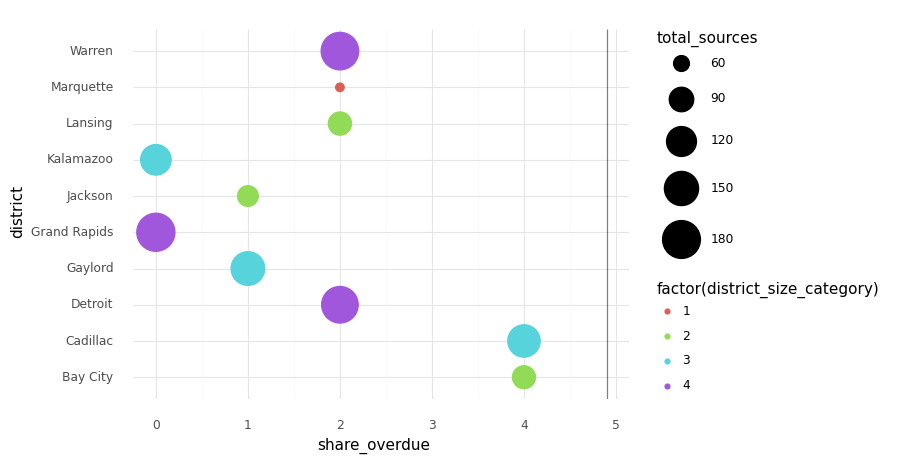

<ggplot: (340154652)>

In [139]:
chart = (
    ggplot(overdue_all_district, aes(x='share_overdue', y='district', size='total_sources')) + 
        geom_point() +
        scale_size_continuous(range =(3, 15)) + 
        geom_vline(xintercept=[4.9],alpha=.5) +
        theme(figure_size=(9,9)) +
        theme_minimal()
)

chart.save("overdue-6mo-district-all-sources-3.svg")
chart
# Thought - make each dot a source, make X="overdue", turn this into a "beeswarm" type chart. Look up geom_jitter or just google how to make a beeswarm or ballswarm with ggplot

### Now I want to classify each evaluation based on whether or not it was overdue and by how much

In [176]:
categories = []
for index, row in multiple_docs_df.iterrows():
    one_source = {}
    
    # Saving SRN & Evaluation Date for merging
    one_source['srn'] = row.srn
    one_source['date_of_evaluation'] = row.date_of_evaluation
    
    # If the source is "MAJOR"
    if row.epa_class == "MAJOR":
        
        # It's under-inspected if it's over 2 years
        if row.dif > 2.25:
            one_source['under_inspected'] = 1
            
            # Categorizing HOW under_inspected it is
            if row.dif < 2.5:
                one_source['category_3mo'] = 1
                one_source['category_6mo'] = 1
            elif row.dif <=2.75:
                one_source['category_3mo'] = 2
                one_source['category_6mo'] = 1 
            elif row.dif <=3:
                one_source['category_3mo'] = 3
                one_source['category_6mo'] = 2
            elif row.dif <= 3.25:
                one_source['category_3mo'] = 4
                one_source['category_6mo'] = 2
            elif row.dif <= 3.5:
                one_source['category_3mo'] = 5
                one_source['category_6mo'] = 3  
            elif row.dif <= 3.75:
                one_source['category_3mo'] = 6
                one_source['category_6mo'] = 3
            elif row.dif <=4:
                one_source['category_3mo'] = 7
                one_source['category_6mo'] = 4  
            else:
                one_source['category_3mo'] = 8
                one_source['category_6mo'] = 4

        else:
            one_source['under_inspected'] = 0       
            one_source['category_3mo'] = 0
            one_source['category_6mo'] = 0
            
    # If the source is "SMOPTOUT"
    elif row.epa_class == "SMOPTOUT":
        
        # It's under-inspected if it's over 5 years
        # Grace period of 3 months?
        if row.dif > 5.25:
            one_source['under_inspected'] = 1
        
            # Categorizing HOW under_inspected it is            
            if row.dif < 5.5:
                one_source['category_3mo'] = 1
                one_source['category_6mo'] = 1
            elif row.dif <=5.75:
                one_source['category_3mo'] = 2
                one_source['category_6mo'] = 1    
            elif row.dif <=6:
                one_source['category_3mo'] = 3
                one_source['category_6mo'] = 2
            elif row.dif <= 6.25:
                one_source['category_3mo'] = 4
                one_source['category_6mo'] = 2
            elif row.dif <= 6.5:
                one_source['category_3mo'] = 5
                one_source['category_6mo'] = 3   
            elif row.dif <= 6.75:
                one_source['category_3mo'] = 6
                one_source['category_6mo'] = 3
            elif row.dif <=7:
                one_source['category_3mo'] = 7
                one_source['category_6mo'] = 4
            else:
                one_source['category_3mo'] = 8
                one_source['category_6mo'] = 4
        else:
            one_source['under_inspected'] = 0
            one_source['category_3mo'] = 0
            one_source['category_6mo'] = 0
    
    elif row.epa_class == "MEGASITE":
        
        # It's under-inspected if it's over 3 years
        if row.dif > 3.25:
            one_source['under_inspected'] = 1
            # Categorizing HOW under_inspected it is
            if row.dif < 3.5:
                one_source['category_3mo'] = 1
                one_source['category_6mo'] = 1
            elif row.dif <=3.75:
                one_source['category_3mo'] = 2
                one_source['category_6mo'] = 1
            elif row.dif <=4:
                one_source['category_3mo'] = 3
                one_source['category_6mo'] = 2
            elif row.dif <= 4.25:
                one_source['category_3mo'] = 4
                one_source['category_6mo'] = 2
            elif row.dif <= 4.5:
                one_source['category_3mo'] = 5
                one_source['category_6mo'] = 3 
            elif row.dif <= 4.75:
                one_source['category_3mo'] = 6
                one_source['category_6mo'] = 3
            elif row.dif <=5:
                one_source['category_3mo'] = 7
                one_source['category_6mo'] = 4
            else:
                one_source['category_3mo'] = 8
                one_source['category_6mo'] = 4
        else:
            one_source['under_inspected'] = 0
            one_source['category_3mo'] = 0
            one_source['category_6mo'] = 0
    else:
        one_source['under_inspected'] = 0
        one_source['category_3mo'] = 0
        one_source['category_6mo'] = 0
# MINOR sources don't have goals, so we will not include them
    categories.append(one_source)
categories_df = pd.DataFrame(categories)
categories_df.head(10)

,srn,date_of_evaluation,under_inspected,category_3mo,category_6mo
0,P0789,2022-03-17,0,0,0
1,B1991,2022-02-28,0,0,0
2,B2644,2022-02-22,0,0,0
3,N0854,2022-02-10,0,0,0
4,N1652,2022-01-27,0,0,0
5,N2039,2022-01-20,0,0,0
6,N3517,2022-01-18,0,0,0
7,N2901,2022-01-13,0,0,0
8,N5732,2021-12-17,0,0,0
9,N6874,2021-12-09,1,7,4


In [177]:
category_3mo_dict = {
    0: "0: On Time",
    1: "1: 3-6 months",
    2: "2: 6-9 months",
    3: "3: 9-12 months",
    4: "4: 1y-1y3m",
    5: "5: 1y3m-1y6m",
    6: "6: 1y6m-1y9m",
    7: "7: 1y9m-2y",
    8: "8: 2+ years"
}

category_6mo_dict = {
    0: "0: On Time",
    1: "1: 3-9 months",
    2: "2: 9-15 months",
    3: "3: 15-21 months",
    4: "4: More than 21 months"
}

categories_df['3mo_text'] = categories_df.category_3mo.map(category_3mo_dict)
categories_df['6mo_text'] = categories_df.category_6mo.map(category_6mo_dict)

In [178]:
print(len(multiple_docs_df))
print(len(categories))
print(len(over_under_goal))

5458
5458
5458


In [179]:
# Merging the documents with the categories and whether or not it was over or under goal
multiple_docs_merge = multiple_docs_df.merge(categories_df,how="left",left_on=['srn','date_of_evaluation'],right_on=['srn','date_of_evaluation'])
multiple_docs_merge = multiple_docs_merge.merge(over_under_goal_df,how="left",left_on=['srn','date_of_evaluation'],right_on=['srn','date_of_evaluation'])
multiple_docs_merge

,date_of_evaluation,srn,facility_name,address,city,county,district,epa_class,dif,under_inspected,category_3mo,category_6mo,3mo_text,6mo_text,time_over_under_goal
0,2022-03-17,P0789,"KALITTA AIR, LLC",5063 SKYWAY STREET,OSCODA,IOSCO,Bay City,SMOPTOUT,3.47,0,0,0,0: On Time,0: On Time,-1.53
1,2022-02-28,B1991,GM LLC Saginaw Metal Casting Operations,1629 N. WASHINGTON,SAGINAW,SAGINAW,Bay City,MAJOR,1.43,0,0,0,0: On Time,0: On Time,-0.57
2,2022-02-22,B2644,Hemlock Semiconductor Operations LLC,12334 Geddes Rd.,HEMLOCK,SAGINAW,Bay City,MAJOR,1.93,0,0,0,0: On Time,0: On Time,-0.07
3,2022-02-10,N0854,TI GROUP AUTOMOTIVE SYSTEMS LLC - Caro Test Ce...,628 COLUMBIA ST,CARO,TUSCOLA,Bay City,MAJOR,1.40,0,0,0,0: On Time,0: On Time,-0.60
4,2022-01-27,N1652,West Branch Production Gathering & Compressor ...,2251 SIMMONS RD,WEST BRANCH,OGEMAW,Bay City,SMOPTOUT,3.06,0,0,0,0: On Time,0: On Time,-1.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459,2022-05-11,P0640,MDOC Chippewa Complex,4269 W. M-80,KINCHELOE,CHIPPEWA,Marquette,SM OPT OUT,0.00,0,0,0,0: On Time,0: On Time,0.00
5460,2022-05-11,P0640,MDOC Chippewa Complex,4269 W. M-80,KINCHELOE,CHIPPEWA,Marquette,SM OPT OUT,0.00,0,0,0,0: On Time,0: On Time,0.00
5461,2022-05-11,P0640,MDOC Chippewa Complex,4269 W. M-80,KINCHELOE,CHIPPEWA,Marquette,SM OPT OUT,0.00,0,0,0,0: On Time,0: On Time,0.00
5462,2022-05-11,P0640,MDOC Chippewa Complex,4269 W. M-80,KINCHELOE,CHIPPEWA,Marquette,SM OPT OUT,0.00,0,0,0,0: On Time,0: On Time,0.00


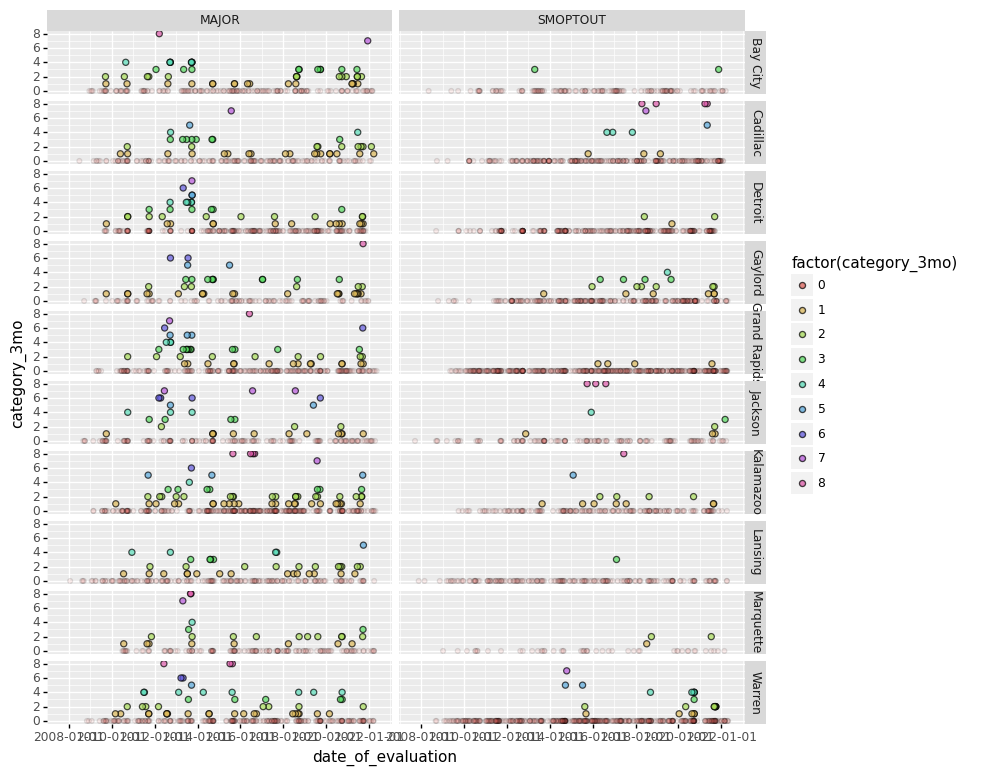

<ggplot: (340220465)>

In [185]:
interest = ['MAJOR','SMOPTOUT']
(
    ggplot(multiple_docs_merge.query('epa_class.isin(@interest) and category_3mo>0'), aes(x="date_of_evaluation",y="category_3mo",fill="factor(category_3mo)"))
    + geom_point(size=2,alpha=.7)
    + geom_point(multiple_docs_merge.query('epa_class.isin(@interest) and category_3mo==0'), aes(x="date_of_evaluation",y="category_3mo"),size=1.5,alpha=.1)
    + facet_grid("district ~ epa_class")
    + theme(figure_size=(9,9))
)

In [186]:
pd.crosstab(df_merge.category_3mo,df_merge.district)

district,Bay City,Cadillac,Detroit,Gaylord,Grand Rapids,Jackson,Kalamazoo,Lansing,Marquette,Warren
category_3mo,,,,,,,,,,
0,329,479,592,429,738,311,625,413,227,822
1,16,21,17,26,18,15,30,15,9,25
2,14,9,12,12,9,4,23,11,12,16
3,12,8,6,14,11,5,7,5,2,6
4,8,5,5,1,3,4,1,4,1,13
5,1,2,2,2,3,2,4,1,0,3
6,0,0,1,2,2,4,1,0,0,2
7,1,2,1,0,1,3,1,0,1,1
8,2,4,0,1,1,3,5,0,2,3


In [187]:
pd.crosstab(df_merge.query('epa_class == "MAJOR"').district,df_merge.query('epa_class == "MAJOR"')['3mo_text'],normalize="index").round(2).sort_values("0: On Time")

3mo_text,0: On Time,1: 3-6 months,2: 6-9 months,3: 9-12 months,4: 1y-1y3m,5: 1y3m-1y6m,6: 1y6m-1y9m,7: 1y9m-2y,8: 2+ years
district,,,,,,,,,
Gaylord,0.73,0.13,0.04,0.06,0.00,0.01,0.01,0.00,0.01
Bay City,0.77,0.08,0.07,0.05,0.04,0.00,0.00,0.00,0.00
Cadillac,0.81,0.09,0.04,0.04,0.01,0.00,0.00,0.00,0.00
Jackson,0.84,0.06,0.02,0.02,0.02,0.01,0.02,0.02,0.00
Lansing,0.84,0.07,0.05,0.02,0.02,0.00,0.00,0.00,0.00
Grand Rapids,0.85,0.05,0.03,0.04,0.01,0.01,0.01,0.00,0.00
Kalamazoo,0.85,0.06,0.05,0.02,0.00,0.01,0.00,0.00,0.01
Marquette,0.85,0.05,0.06,0.01,0.01,0.00,0.00,0.01,0.01
Warren,0.85,0.07,0.03,0.02,0.03,0.00,0.01,0.00,0.01


## Plotting

###  Distribution of FCEs by the duration before, district and source class.
* Duration before means how long of a gap there was before an FCE.

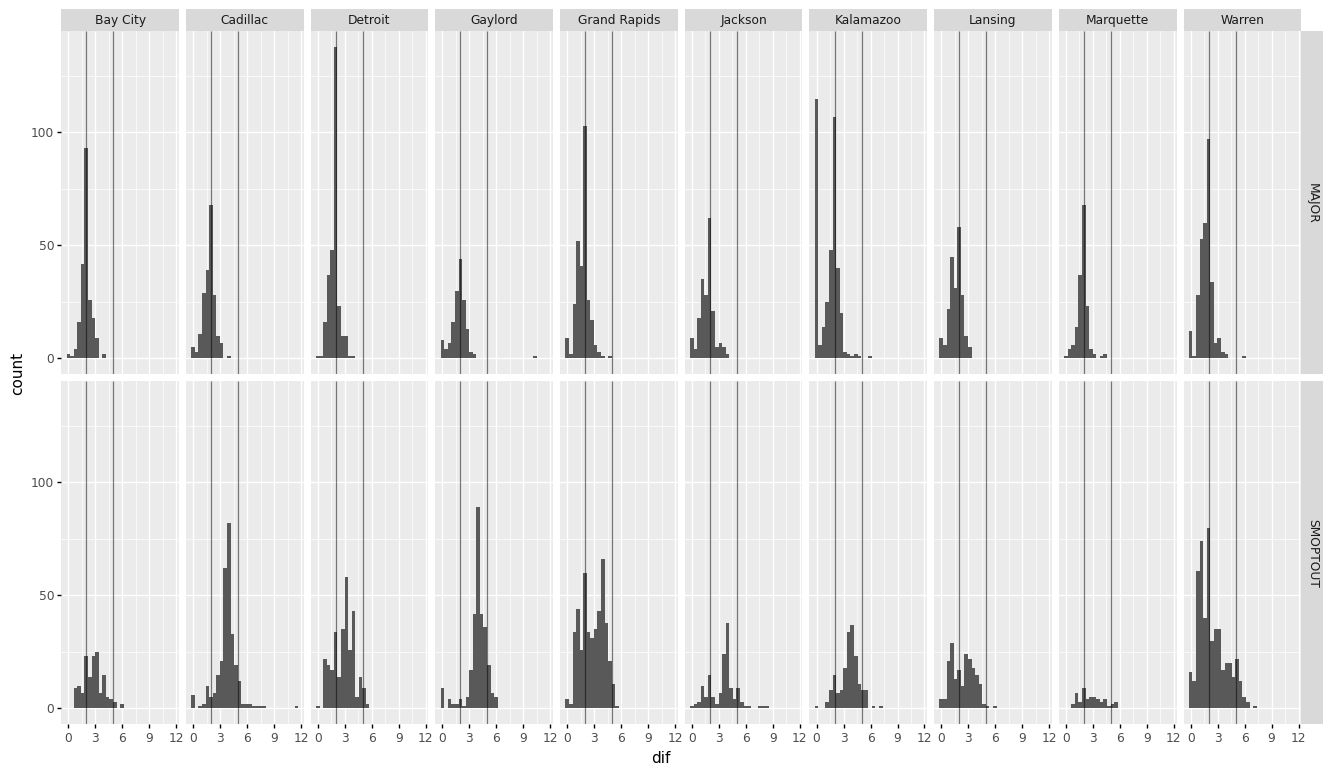

<ggplot: (341886094)>

In [191]:
interest = ['MAJOR','SMOPTOUT']
(
    ggplot(multiple_docs_df.query('epa_class.isin(@interest)'),aes(x='dif'))
    +geom_histogram(bins=30)
    +geom_vline(xintercept=[2,5],alpha=.5)
    +facet_grid('epa_class ~ district')
    + theme(figure_size=(16,9))
)

###  Distribution of Major Source FCEs by the date, duration before, and district.


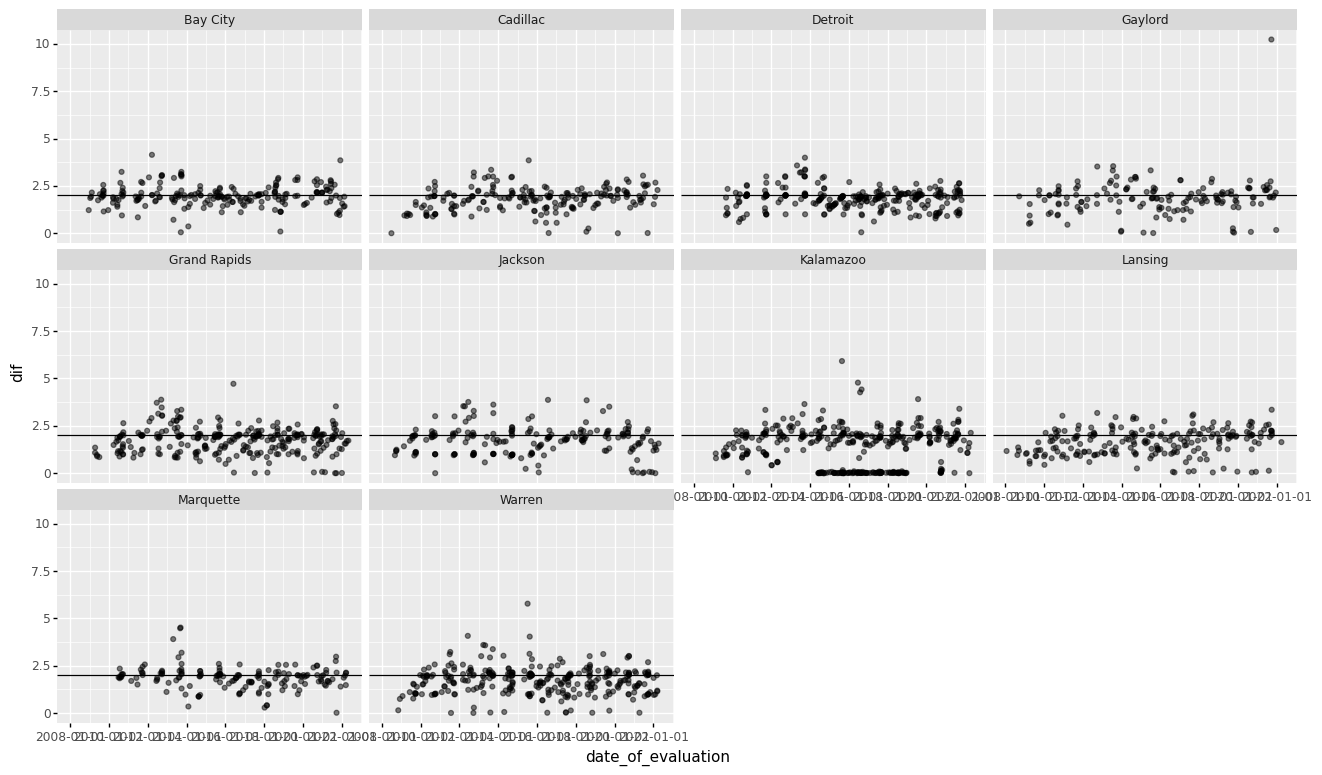

<ggplot: (343534909)>

In [192]:
interest = ['MAJOR']
(
    ggplot(multiple_docs_df.query('epa_class.isin(@interest)'),aes(x='date_of_evaluation',y="dif"))
    +geom_point(alpha=.5)
    + geom_hline(aes(yintercept='2'))
#     +geom_vline(yintercept=[2,5],alpha=.5)
    + facet_wrap('district')
    + theme(figure_size=(16,9))
)



###  Distribution of Synthetic Minor FCEs by the date, duration before, and district.

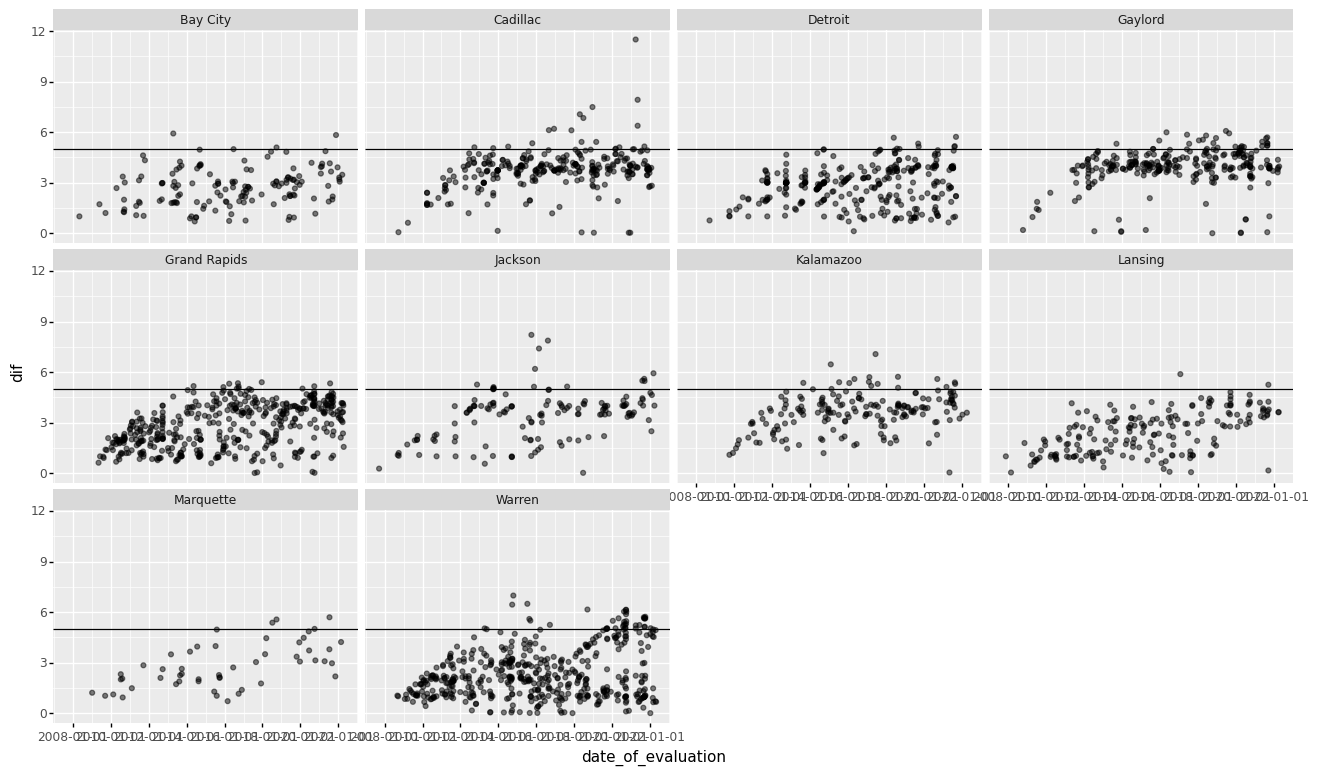

<ggplot: (341882784)>

In [193]:
interest = ['SMOPTOUT']
(
    ggplot(multiple_docs_df.query('epa_class.isin(@interest)'),aes(x='date_of_evaluation',y="dif"))
    +geom_point(alpha=.5)
    + geom_hline(aes(yintercept='5'))
#     +geom_vline(yintercept=[2,5],alpha=.5)
    + facet_wrap('district')
    + theme(figure_size=(16,9))
)

###  Distribution of Megasite FCEs by the date, duration before, and district.

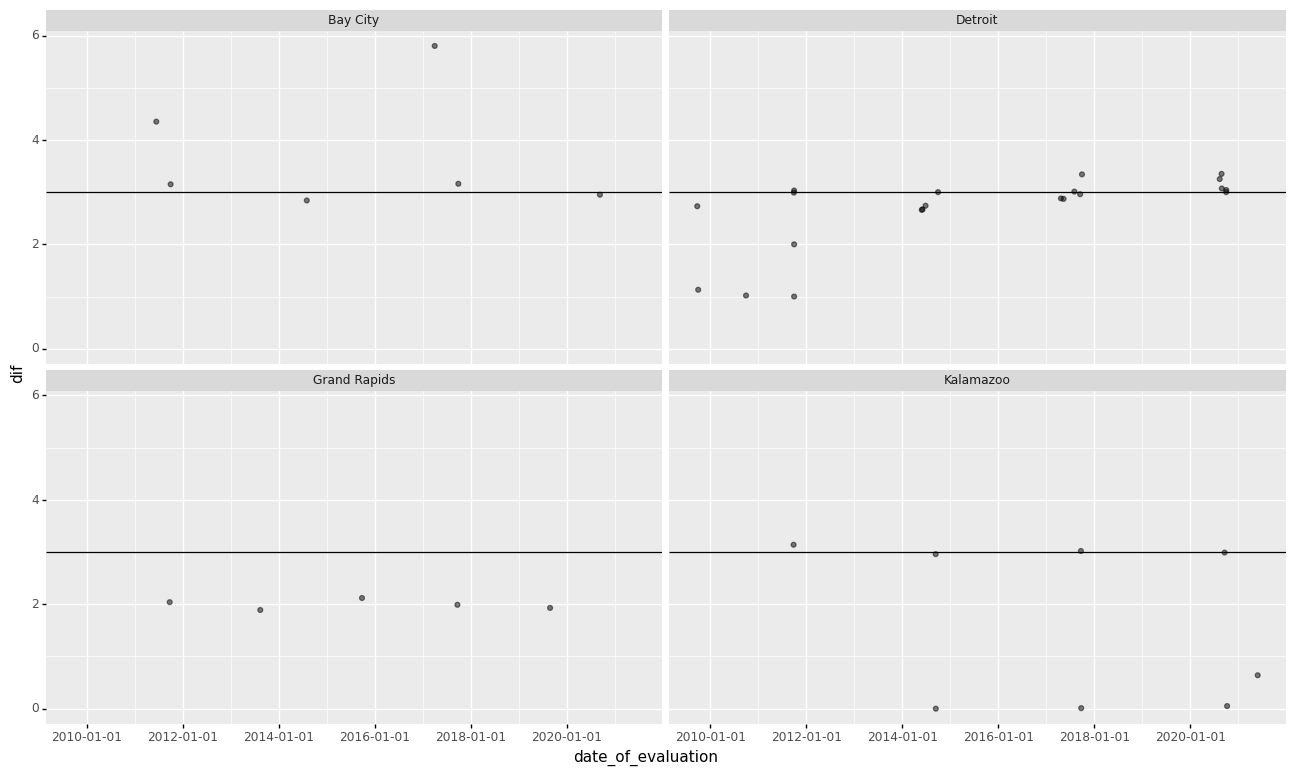

<ggplot: (343180810)>

In [194]:
interest = ['MEGASITE']
(
    ggplot(multiple_docs_df.query('epa_class.isin(@interest)'),aes(x='date_of_evaluation',y="dif"))
    +geom_point(alpha=.5)
    + geom_hline(aes(yintercept='3'))
#     +geom_vline(yintercept=[2,5],alpha=.5)
    + facet_wrap('district')
    + theme(figure_size=(16,9))
)

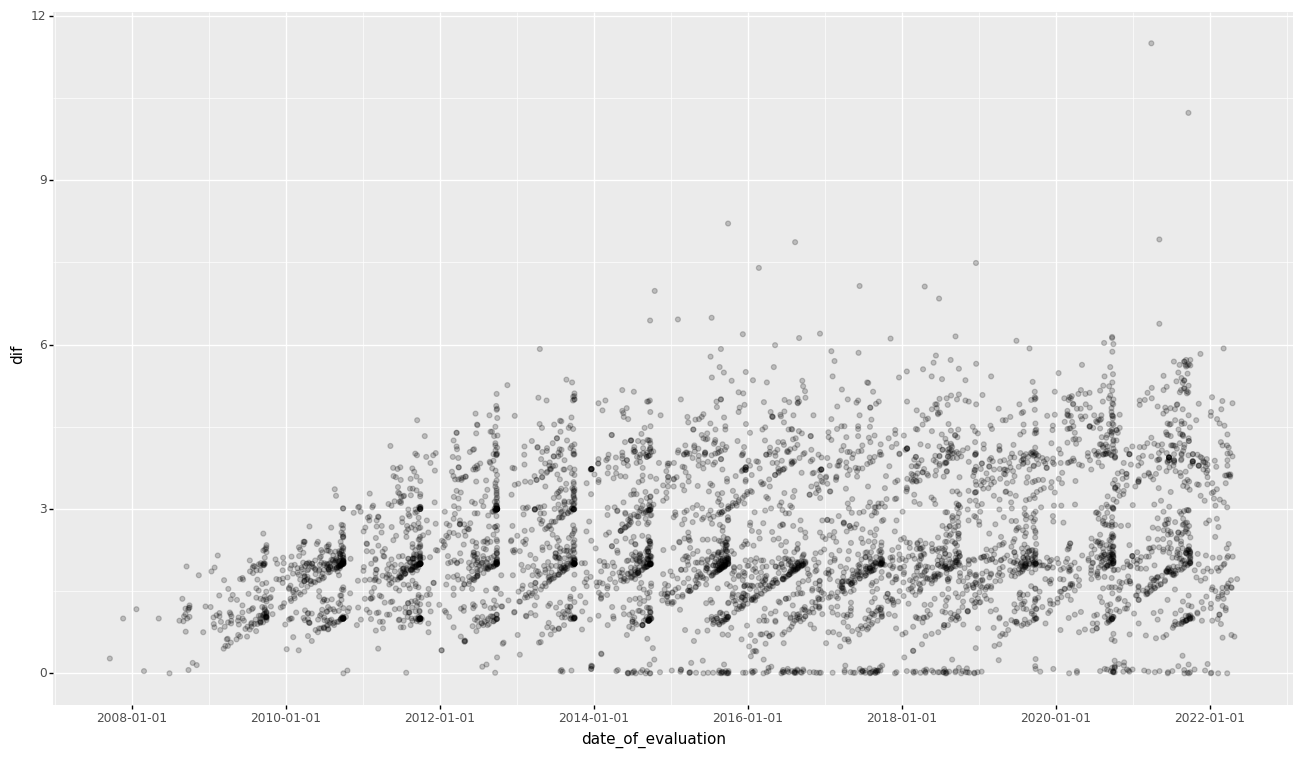

<ggplot: (342011564)>

In [195]:
# Both sources no division by district
interest = ['MAJOR','SMOPTOUT']
(
    ggplot(multiple_docs_df.query('epa_class.isin(@interest)'),aes(x='date_of_evaluation',y="dif"))
    +geom_point(alpha=.2)
#     +geom_point(df_multiple.query('county == "WAYNE"'),aes(x='date_of_evaluation',y="dif",color='factor(county)'))
#     +geom_vline(yintercept=[2,5],alpha=.5)
    + theme(figure_size=(16,9))
)